In [2]:
import numpy
import matplotlib.pyplot as plt
import diplo_locus.likelihood
import diplo_locus.simulate
import scipy.stats
import scipy.special
import scipy.interpolate
import scipy.optimize
# import seaborn
import pandas
# import xinyi_sardinia_common

numpy.random.seed (667)

In [3]:
def stackSamples (theSamples):

    # get dimensions
    tmp = [x.shape[1] for x in theSamples.values()]
    repLength = tmp[0]
    assert ((len(tmp) == 0) or (numpy.all (numpy.diff (tmp) == 0)))
    totaSims = numpy.sum ([x.shape[0] for x in theSamples.values()])

    # create storage
    allSamples = - numpy.ones ((totaSims, repLength), dtype=int)

    # storage for the indices
    startIdx = 0
    endIdx = startIdx
    batchIdxs = {}

    # go through and enter
    for (k,v) in theSamples.items():

        # update indices
        startIdx = endIdx
        endIdx = startIdx + v.shape[0]

        # store sample
        allSamples[startIdx:endIdx,:] = v

        # remember indices
        batchIdxs[k] = (startIdx, endIdx)

    # make sure stuff is ok
    assert (numpy.all (allSamples > -1))

    # then return combined thing, but also indices
    return (allSamples, batchIdxs)


In [4]:
def findMaxOneD (params, ll):

    # make an interp function
    f = scipy.interpolate.interp1d (params, ll, kind="cubic")

    # the right bounds
    bounds = (min(params),max(params))

    # and find the optimum (minus, cause we can only minimize)
    daOpt = scipy.optimize.minimize_scalar (lambda x : - f(x), method='bounded', bounds=(bounds[0], bounds[1]))

    # return the results
    maxParam = float(daOpt.x)
    maxLL = - float(daOpt.fun)

    return numpy.array ([maxParam, maxLL])


### simulate

In [5]:
# popgen params
diffMAlpha = 0
diffMBeta = 0
Ne = 10000

# selection coefficients
# need to be strings for indexing
# selCoeffs = [ f"{x:.6f}" for x in numpy.linspace (-0.2, 0.2, 9)]
# selCoeffs = [ f"{x:.6f}" for x in numpy.linspace (0, 0.2, 5)]
simCoeffs = [ f"{x:.6f}" for x in [0, 0.005, 0.01, 0.05, 0.1]]

# simulation params
deltaT = 1/20
numReplicates = 256

samplingTimes = numpy.linspace (0, 300, 11)
sampleSizes = 50 * numpy.ones (len(samplingTimes), dtype=int)

In [6]:
# specifiy initial condition for simulations

# given frequency
simInitDict = {'initCond' : 'initFreq', "initFreq" : 0.1}

# # this should be uniform distribution
# simInitDict = {'initCond' : 'contBeta', "initMAlpha" : 1/(4 * Ne), "initMBeta" : 1/(4 * Ne)}


In [7]:
theSamples = {}
theTrajectories = {}

# now simulate a bunch of samples
for s2 in simCoeffs:

    print (s2)

    # simulate 
    thisSamplingTimes = numpy.concatenate (([0], samplingTimes))
    (thisSample, thisTrajectory) = diplo_locus.simulate.simulateSamples (Ne, 0.5*float(s2), float(s2),
                                                    diffMAlpha, diffMBeta, thisSamplingTimes, sampleSizes,
                                                    numReplicates=numReplicates, deltaT=deltaT,
                                                    **simInitDict)

    # and keep
    theSamples[s2] = thisSample
    theTrajectories[s2] = thisTrajectory
    

0.000000
0.005000
0.010000
0.050000
0.100000


Text(0.5, 1.0, 's2 = 0.005000')

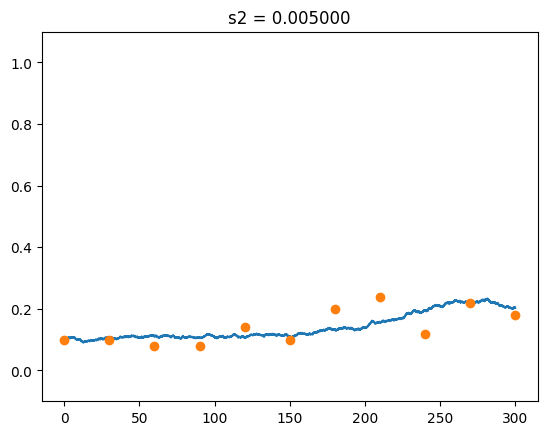

In [8]:
repS2 = simCoeffs[1]
repIdx = 7
xs = numpy.arange (theTrajectories[repS2].shape[1]) * deltaT
plt.plot (xs, theTrajectories[repS2][repIdx,:])
plt.plot (samplingTimes, theSamples[repS2][repIdx,:]/sampleSizes, "o")
plt.ylim ((-0.1,1.1))
plt.title (f"s2 = {repS2}")

### analyze

In [16]:
# stack the samples, but remember where you stacked them
(allSamples, batchIdxs) = stackSamples (theSamples)


In [17]:
# specify initial condition

# give frequency
analysisInitDict = {'initCond' : 'initFreq', 'initFreq' : 0.1}

# uniform inital distribution
# analysisInitDict = {'initCond' : 'uniform'}

In [18]:
preCoeffs = numpy.geomspace (0.005, 0.5, 11)
selCoeffs = numpy.concatenate (( - numpy.flip(preCoeffs), [0], preCoeffs))

In [20]:
%%time
# get a likelihood surface
genicDirection = [0.5, 1]
tmpSamplingTimes = numpy.concatenate (([0], samplingTimes))
# theseSampleSizes = numpy.repeat ([tmpSamplingTimes], thisSample.shape[0], axis=0)
theseSampleSizes = numpy.repeat ([sampleSizes], allSamples.shape[0], axis=0)
(ll, selGrid) = diplo_locus.likelihood.surfaceOneD (tmpSamplingTimes, theseSampleSizes, allSamples, genicDirection, selCoeffs,
                                                    **analysisInitDict, emissionType="integer", sampleSizesSet=set(sampleSizes),
                                                    transitionType="constant", mAlpha=diffMAlpha, mBeta=diffMBeta, Ne=Ne)
# make it easier on the eye
# ll = ll[0,:]

-0.25 -0.5
-0.1577393361200483 -0.3154786722400966
-0.09952679263837431 -0.19905358527674863
-0.06279716078773952 -0.12559432157547903
-0.03962232981152785 -0.0792446596230557
-0.024999999999999998 -0.049999999999999996
-0.01577393361200483 -0.03154786722400966
-0.009952679263837432 -0.019905358527674864
-0.006279716078773948 -0.012559432157547895
-0.0039622329811527844 -0.007924465962305569
-0.0025 -0.005
0.0 0.0
0.0025 0.005
0.0039622329811527844 0.007924465962305569
0.006279716078773948 0.012559432157547895
0.009952679263837432 0.019905358527674864
0.01577393361200483 0.03154786722400966
0.024999999999999998 0.049999999999999996
0.03962232981152785 0.0792446596230557
0.06279716078773952 0.12559432157547903
0.09952679263837431 0.19905358527674863
0.1577393361200483 0.3154786722400966
0.25 0.5
CPU times: user 6min 11s, sys: 2min 39s, total: 8min 51s
Wall time: 2min 23s


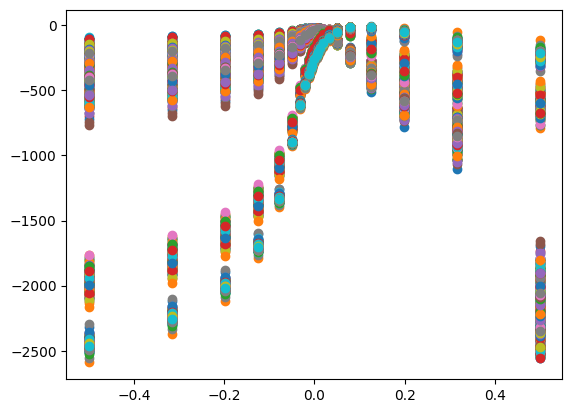

In [21]:
# all surfaces
for idx in numpy.arange (ll.shape[0]):
    plt.plot (selGrid[:,1], ll[idx,:], 'o')
# plt.xlim (-0.05,0.05)
# plt.ylim (-35, -29)

In [22]:
zeroSelIdx = numpy.where(numpy.isclose(0, selGrid[:,1]))[0][0]

# get maxima on interpolated function
mleAndLlRatio = numpy.zeros ((allSamples.shape[0], 2))

for idx in numpy.arange (allSamples.shape[0]):

    # get max and ll
    (maxParam, maxLL) = findMaxOneD (selGrid[:,1], ll[idx,:])

    # get ll at zero
    neutralLL = ll[idx,zeroSelIdx]

    # get llratio stat
    llRatio = 2*(maxLL - neutralLL)

    # we might be slightly negative here, so make sure to only return 0s
    if (llRatio < 0):
        # that is pretty lenient, but I guess so
        if (llRatio > -1e-10):
            llRatio = 0
        else:
            assert (False), f"Numerics for minimum to imprecise: {llRatio}."


    mleAndLlRatio[idx,:] = numpy.array([maxParam, 2*(maxLL - neutralLL)])

(-0.15, 0.15)

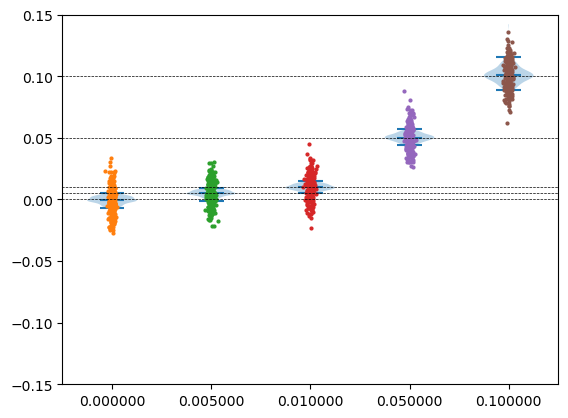

In [20]:
# box plots or violins
categoryList = []
data = []

# slice the data in the right way
for k in batchIdxs.keys():
    v = batchIdxs[k]

    # remember category
    categoryList.append (k)

    # remember data
    estimates = mleAndLlRatio[v[0]:v[1],0]
    data.append (estimates)

# do some plot
xCoords = numpy.arange(len(categoryList))
theQuantiles = [[0.025,0.975]]*(len(categoryList))
violinDict = plt.violinplot (data, xCoords, showmedians=True, showextrema=False, quantiles=theQuantiles)

plt.xticks (numpy.arange(len(categoryList)), categoryList)
# plt.xlabel (categoryList)

# some jittering for points
for (idx, thisData) in enumerate (data):
    jitterX = numpy.random.normal (loc=xCoords[idx], scale=0.02, size=len(thisData))
    jitterY = numpy.random.normal (loc=thisData, scale=0.01)
    plt.plot (jitterX, jitterY, "o", markersize=2)

# some cosmetics
plt.xlim (xCoords.min() - 0.5, xCoords.max() + 0.5)
for truth in categoryList:
    plt.plot ([-1e8, 1e8], [float(truth), float(truth)], "--", linewidth=0.5, color="black")
# just some mins and maxes
minSel = selGrid[:,1].min()
maxSel = selGrid[:,1].max()
plt.plot ([-1e8, 1e8], [maxSel, maxSel], "--", linewidth=0.5, color="red")
plt.plot ([-1e8, 1e8], [minSel, minSel], "--", linewidth=0.5, color="red")
# plt.ylim (-0.15, 0.6)
plt.ylim (-0.15, 0.15)
